# Define Paths

In [5]:
pathTo95TVA2DVASample = "localData/95TVA2DVASample/"
gold_standard_path = "localData/gold_standards/"
#ALL Pair sample can be found in TODO: insert link!
allPairsSamplePath = "<REPLACE THIS>"

# Print Recall Table of RSG or DGS (Table 3):

In [3]:
import role_matching.EvaluationHelperMethods as rm
import role_matching.MetricHelperMethods as mhm
import pandas as pd
from plotnine import *
from plotnine.data import *
from tabulate import tabulate
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, precision_recall_curve
import numpy as np

bucketAndDatasetToWeight, _ = rm.getBucketAndDatasetToWeight(pathTo95TVA2DVASample)

loadDiverseGoldStandard = False
if(loadDiverseGoldStandard):
    weighted = False
else:
    weighted = True
df = rm.readGoldStandardEvaluation(gold_standard_path,loadDiverseGoldStandard,pathTo95TVA2DVASample)
methodNames = ['isInExactMatchBlockingWithFilter','isInStrictBlockingNoDecayWithFilter','isInSequenceBlockingWithFilter','isInTSMBlockingWithFilter','isInValueSetBlockingWithFilter']

print("dataset","#TP","EM","CBRB","QSM","TSM","VSM",sep=",")
print("," + (",R"* (len(methodNames))))
dsNameList = []
for dsName in df['dataset'].unique():
    dsNameList.append(dsName)
dsNameList.sort()
for dsName in dsNameList:
    shortName = rm.datasetToAbbreviation[dsName]
    mhm.printRecallForNonparametrizedMethodsDF(shortName,df[df['dataset']==dsName],methodNames,weighted,bucketAndDatasetToWeight)
mhm.printRecallForNonparametrizedMethodsDF("Micro-AVG",df,methodNames,weighted,bucketAndDatasetToWeight)
mhm.printMacroAveragesRecall("Macro-AVG",df,methodNames,weighted,bucketAndDatasetToWeight)

dataset,#TP,EM,CBRB,QSM,TSM,VSM
,,R,R,R,R,R
ED,20,41,47,67,67,67
FO,7,100,100,100,100,100
MI,21,18,85,44,69,69
PO,33,37,62,66,76,78
TV,58,7,50,78,99,99
Micro-AVG,139,27,59,68,80,81
Macro-AVG,,41,69,71,82,82,

In [11]:
print(df[(df['isSemanticRoleMatch']) & (df['isInStrictBlockingNoDecay']) & (~df['isInStrictBlockingNoDecayWithFilter'])][['id1','id2']])
df[(df['isSemanticRoleMatch']) & (df['isInStrictBlockingNoDecay']) & (~df['isInStrictBlockingNoDecayWithFilter'])][['dataset','id1','id2']].to_csv("gs1errors.csv")
#df["newLabel"] = (df['isSemanticRoleMatch']) | ((df['isSemanticRoleMatch']) & (df['isInStrictBlockingNoDecay']) & (~df['isInStrictBlockingNoDecayWithFilter']))
#print(sum(df["newLabel"]))
#print(sum(df["isSemanticRoleMatch"]))

Empty DataFrame
Columns: [id1, id2]
Index: []


# Print How Many True Positives could correct Data quality errors (Introduction):

In [12]:
df1 = rm.readGoldStandardEvaluation(gold_standard_path,True,pathTo95TVA2DVASample)
df2 = rm.readGoldStandardEvaluation(gold_standard_path,True,pathTo95TVA2DVASample)
dfAll = df1.append(df2)
dfAllTP = dfAll[dfAll['isSemanticRoleMatch']]
print(sum(dfAllTP["hasNonOverlap"]) / len(dfAllTP.index))
print(sum(~ dfAllTP["isInStrictBlockingNoDecay"]) / len(dfAllTP.index))
print(sum( dfAllTP["compatibilityPercentageNoDecay"] != 1.0) / len(dfAllTP.index))

0.32679738562091504
0.24183006535947713
0.24183006535947713


/tmp/ipykernel_81200/3615401763.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


# Gold Standard Overview (Figure 6)

In [13]:
# true positives:
dfTruePositivesOnly = df[df['isSemanticRoleMatch']]
tab = dfTruePositivesOnly.groupby(['dataset','bucket']).size()
print(tab)

dataset      bucket          
education    [0.0,0.7) (<70%)     2
             [0.7,1.0) (70%)      2
             [1.0,1.0] (full)    15
football     [0.7,1.0) (70%)      3
             [1.0,1.0] (full)    41
military     [0.0,0.7) (<70%)     5
             [0.7,1.0) (70%)      4
             [1.0,1.0] (full)    12
politics     [0.0,0.7) (<70%)     6
             [0.7,1.0) (70%)      7
             [1.0,1.0] (full)    20
tv_and_film  [0.0,0.7) (<70%)     3
             [0.7,1.0) (70%)      5
             [1.0,1.0] (full)    28
dtype: int64


/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


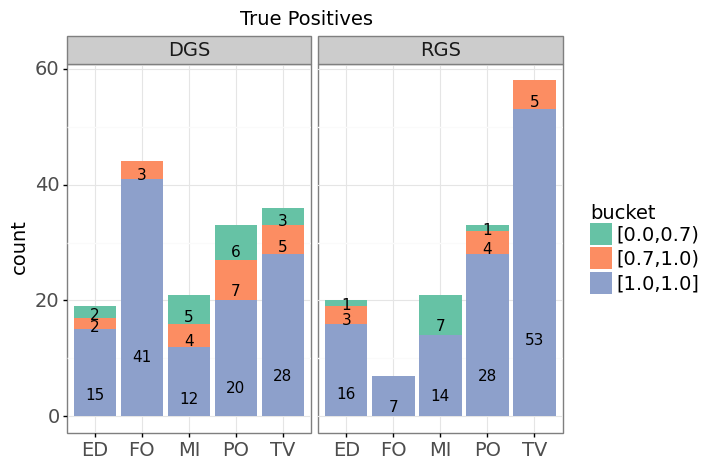

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/truePositivesBoth.png
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [14]:
import role_matching.EvaluationHelperMethods as rm
loadDiverseGoldStandard=True # old or new gold standard

df1 = rm.readGoldStandardEvaluation(gold_standard_path,True,pathTo95TVA2DVASample)
df1["GS"] = "DGS"
df2 = rm.readGoldStandardEvaluation(gold_standard_path,False,pathTo95TVA2DVASample)
df2["GS"] = "RGS"

rm.addShortDataset(df1)
rm.addShortDataset(df2)
df1['bucket'] = df1['compatibilityPercentageNoDecay'].map(lambda x: rm.getShortGroup(x))
df2['bucket'] = df2['compatibilityPercentageNoDecay'].map(lambda x: rm.getShortGroup(x))

dfTruePositivesOnlyDF1 = df1[df1['isSemanticRoleMatch']]
dfTruePositivesOnlyDF2 = df2[df2['isSemanticRoleMatch']]
dfAllPositives = pd.concat([dfTruePositivesOnlyDF1,dfTruePositivesOnlyDF2])

cbPalette = ["#1b9e77", "#d95f02", "#7570b3", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

plot = ggplot(dfAllPositives,aes(x = 'datasetShort',fill="bucket")) +xlab("") + geom_bar(stat = "count") + facet_wrap("GS") + theme_bw() + ggtitle("True Positives") + theme(text=element_text(size=14)) +  geom_text(aes(label = "..count.."),position = position_stack(vjust = 0.25), stat = "count")+ scale_fill_brewer(type="qual",palette="Set2")
print(plot)
plot.save("exportedPlots/truePositivesBoth.png")


# Reduction Ratios of Non-Parametrized Methods (Table 4 and Figure 7)

In [16]:
import glob
import os
import pandas as pd
import role_matching.EvaluationHelperMethods as rm

#Statistics extracted from the sample drawing:
#We drew a sample from the set of all pairs until we had 1 million candidate pairs that had at least one timestamp-value agreement (1TVA)
#Having 1TVA is a prerequisite for a candidate pair in order to be considered
#We tracked how many candidate pairs did not have 1TVA per dataset in order to be able to compute the correct (estimated) reduction ratio
#allPairs denotes the number of all pairs per dataset, nMisses1TVA denotes how many pairs we had to skip (because they were not in 1TVA)
dsToBaseSampleStatistics = {
    "military": {"allPairs":4263199291,"nMisses1TVA":88280922,"nHits1TVA":1000000},
    "tv_and_film": {"allPairs":23657801481,"nMisses1TVA":50646743,"nHits1TVA":1000000},
    "politics": {"allPairs":2223411270,"nMisses1TVA":41041877,"nHits1TVA":1000000},
    "education": {"allPairs":2737889001,"nMisses1TVA":28997770,"nHits1TVA":1000000},
    "football": {"allPairs":53116323211,"nMisses1TVA":38466606,"nHits1TVA":1000000},
}

#these are the files that contain the statistics about the 1 million candidates in TVA (per dataset):
dfAllPairsSample = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', allPairsSamplePath + "/*.csv"))))

methodNames = ['isInValueSetBlockingWithFilter','isInStrictBlockingNoDecayWithFilter',"isInTSMBlockingNoWildcard","isInTSMBlockingWithFilter"]

rm.addFilteredBlockingMethods(dfAllPairsSample)
rm.addDVA2VA95Blocking(dfAllPairsSample)
#rm.addParametrizedScoresAsBooleanScores(dfAllPairsSample)
#print(dfAllPairsSample.columns)
groupedByDS = dfAllPairsSample.groupby("dataset")


dataset,#Total Pairs,EM,CBRB,QSM,TSM,VSM
education,2737889001,0.9999997666493209,0.9999987665749821,0.9999974331425303,0.9999956996803429,0.9999935328526087,
football,53116323211,0.9999997212833553,0.9999979476319804,0.9999633614301671,0.9999550252687044,0.999934197533986,
military,4263199291,0.9999994847723459,0.9999925403996164,0.9999904794889999,0.9999828070771939,0.9999821238405222,
politics,2223411270,0.9999991674967319,0.9999982636360408,0.9999964559146586,0.9999953141958909,0.9999948622655453,
tv_and_film,23657801481,0.9999999612753896,0.9999998063769481,0.9999990706093509,0.9999980250448707,0.9999968052196437,


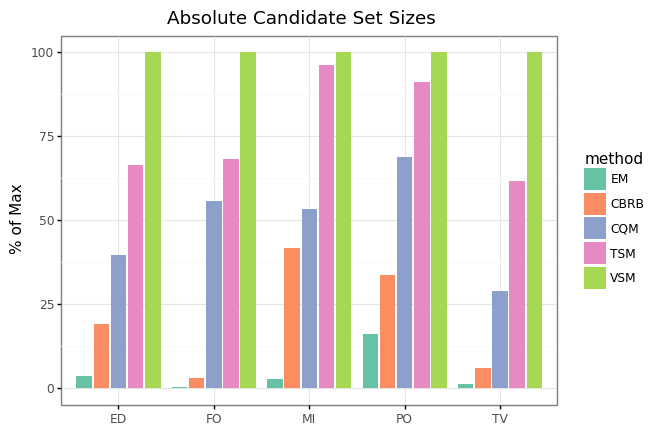

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/absoluteSetSizes.png


In [17]:
import role_matching.MetricHelperMethods as mhm

methodNames = ['isInExactMatchBlockingWithFilter','isInStrictBlockingNoDecayWithFilter','isInSequenceBlockingWithFilter','isInTSMBlockingWithFilter','isInValueSetBlockingWithFilter']

methodNamesToShortMethodName = {
    'isInExactMatchBlockingWithFilter':"EM",
    'isInStrictBlockingNoDecayWithFilter':"CBRB",
    'isInSequenceBlockingWithFilter':"CQM",
    'isInTSMBlockingWithFilter':"TSM",
    'isInValueSetBlockingWithFilter':"VSM"
}
print("dataset","#Total Pairs","EM","CBRB","QSM","TSM","VSM",sep=",")
finalDSRows = []
for (ds,thisDsAllPairsSample) in groupedByDS:
    nAllPairs = dsToBaseSampleStatistics[ds]["allPairs"]
    nHits1TVA = dsToBaseSampleStatistics[ds]["nHits1TVA"]
    nMisses1TVA = dsToBaseSampleStatistics[ds]["nMisses1TVA"]
    estimatedCountSVAPairs = round((nHits1TVA / (nHits1TVA+nMisses1TVA)) * nAllPairs)
    nHits90VA2DA = len(thisDsAllPairsSample[thisDsAllPairsSample['isInDVA2VA95Blocking']].index)
    nMisses90VA2DA = len(thisDsAllPairsSample[thisDsAllPairsSample['isInDVA2VA95Blocking']].index)
    print(ds,nAllPairs,sep=",",end=",")
    for method in methodNames:
        thisDF = thisDsAllPairsSample[thisDsAllPairsSample[method]]
        nHitsThisMethod = len(thisDF.index)
        nMissesThisMethod = nMisses1TVA + len(thisDsAllPairsSample.index) - nHitsThisMethod
        n,rrAll = mhm.getReductionRate(nHitsThisMethod,nMissesThisMethod,nAllPairs)
        finalDSRows.append({"dataset":ds,"method":methodNamesToShortMethodName[method],"n":n,"rr":rrAll})
        _,rr1VA = mhm.getReductionRate(nHitsThisMethod,len(thisDsAllPairsSample) - nHitsThisMethod,estimatedCountSVAPairs)
        rr95 = mhm.getReductionRateToOtherMethod(method,"isInDVA2VA95Blocking",thisDsAllPairsSample)
        print(rrAll,sep=",",end=",")
    print("")
finalDF = pd.DataFrame(finalDSRows)
#get maxima:
grouped = finalDF.groupby("dataset",).agg({'n':"max"}).to_dict("index")
finalDF["% of Max"] = finalDF.apply(lambda r: 100*(r["n"] / grouped[r["dataset"]]["n"]),axis=1)
finalDF['method'] = finalDF['method'].astype("category").cat.reorder_categories(['EM', 'CBRB', "CQM", "TSM", "VSM"])
rm.addShortDataset(finalDF)
plot = ggplot(finalDF,aes(x = 'datasetShort',fill="method",y="% of Max")) +xlab("") + geom_bar(position=position_dodge2(preserve = "single"),stat="identity") + ggtitle("Absolute Candidate Set Sizes") + theme(text=element_text(size=14)) + theme_bw() + scale_fill_brewer(type="qual",palette="Set2")
print(plot)
plot.save("exportedPlots/absoluteSetSizes.png")


# Reduction Ratio parametrized (Figure 8):

In [6]:
import glob
import os
import pandas as pd
import role_matching.EvaluationHelperMethods as rm
import role_matching.MetricHelperMethods as mhm

#same as above
dsToBaseSampleStatistics = {
    "military": {"allPairs":4263199291,"nMisses1TVA":88280922,"nHits1TVA":1000000},
    "tv_and_film": {"allPairs":23657801481,"nMisses1TVA":50646743,"nHits1TVA":1000000},
    "politics": {"allPairs":2223411270,"nMisses1TVA":41041877,"nHits1TVA":1000000},
    "education": {"allPairs":2737889001,"nMisses1TVA":28997770,"nHits1TVA":1000000},
    "football": {"allPairs":53116323211,"nMisses1TVA":38466606,"nHits1TVA":1000000},
}

dfAllPairsParametrized = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', allPairsSamplePath+"*.csv"))))
print(dfAllPairsParametrized.columns)
groupedByDsParametrized = dfAllPairsParametrized.groupby("dataset")

Index(['dataset', 'id1', 'id2', 'RM_Gamma', 'CBRB_Beta', 'Relaxed_CBRB_Gamma',
       'hasTransitionOverlap'],
      dtype='object')


In [7]:
oldGoldStandard = rm.readGoldStandardEvaluation(gold_standard_path,True,pathTo95TVA2DVASample)
newGoldStandard = rm.readGoldStandardEvaluation(gold_standard_path,False,pathTo95TVA2DVASample)
pd.options.mode.chained_assignment = None

thresholds = []
for i in range(101):
    thresholds.append(i/100)
finalDFRows = []
methods = ["RM_Gamma","CBRB_Beta"]

methodsToRecallScoreNames = {
    "RM_Gamma":"exactSequenceMatchPercentage",
    "CBRB_Beta":"decayScore",
    "Relaxed_CBRB_Gamma":"compatibilityPercentageNoDecay"
}

methodsToPlotNames = {
    "RM_Gamma":"RM",
    "CBRB_Beta":"CBRB"
}

bucketAndDatasetToWeight, _ = rm.getBucketAndDatasetToWeight(pathTo95TVA2DVASample)

def getRecall(oldGoldStandard, ds, scoreName, weighted):
    oldGoldStandardFiltered = oldGoldStandard[oldGoldStandard["dataset"]==ds]
    oldGoldStandardFiltered['currentScoreWithCutoff'] = ((oldGoldStandardFiltered[scoreName] !=-1) & (oldGoldStandardFiltered[scoreName]>=t))
    recallDGS = mhm.getRecall(oldGoldStandardFiltered,'currentScoreWithCutoff',weighted,bucketAndDatasetToWeight)
    return recallDGS

print(oldGoldStandard['decayScore'].describe())

for method in methods:
    print("processing",method)
    plotnameMethod = methodsToPlotNames[method]
    for t in thresholds:
    #print("Processing ",ds)
        print("processing",t)
        avgN = 0
        avgRR = 0
        avgRecallDGS = 0
        avgRecallRGS = 0
        for(ds,dfGrouped) in groupedByDsParametrized:
            scoreName = methodsToRecallScoreNames[method]
            #recall old and new gold standard:
            recallDGS = getRecall(oldGoldStandard,ds,scoreName,False)
            recallRGS = getRecall(newGoldStandard,ds,scoreName,True)
            #recall new gold standard:
            #reduction ratio:
            nAllPairs = dsToBaseSampleStatistics[ds]["allPairs"]
            nMisses1TVA = dsToBaseSampleStatistics[ds]["nMisses1TVA"]
            thisDF = dfGrouped[((dfGrouped[method]>=t) & (dfGrouped["hasTransitionOverlap"]))]
            nHitsThisMethod = len(thisDF.index)
            nMissesThisMethod = nMisses1TVA + len(dfGrouped.index) - nHitsThisMethod
            n,rrAll = mhm.getReductionRate(nHitsThisMethod,nMissesThisMethod,nAllPairs)
            if(rrAll>1):
                print(n,rrAll,nHitsThisMethod,nMissesThisMethod,nAllPairs)
            avgN +=n
            avgRR += rrAll
            avgRecallDGS += recallDGS
            avgRecallRGS += recallRGS
            finalDFRows.append({"n":n,"rr":100*rrAll,"method":plotnameMethod,"threshold":t,"dataset":ds,"recall":recallDGS,"GS":"DGS"})
            finalDFRows.append({"n":n,"rr":100*rrAll,"method":plotnameMethod,"threshold":t,"dataset":ds,"recall":recallRGS,"GS":"RGS"})
        avgN = avgN / len(groupedByDsParametrized)
        avgRR = avgRR / len(groupedByDsParametrized)
        avgRecallDGS = avgRecallDGS / len(groupedByDsParametrized)
        avgRecallRGS = avgRecallRGS / len(groupedByDsParametrized)
        finalDFRows.append({"n":avgN,"rr":100*avgRR,"method":plotnameMethod,"threshold":t,"dataset":"MAA","recall":avgRecallDGS,"GS":"DGS"})
        finalDFRows.append({"n":avgN,"rr":100*avgRR,"method":plotnameMethod,"threshold":t,"dataset":"MAA","recall":avgRecallRGS,"GS":"RGS"})
finalDF = pd.DataFrame(finalDFRows)
print(finalDF.describe())

count    1500.000000
mean        0.352927
std         0.616159
min        -1.000000
25%         0.000000
50%         0.330000
75%         1.000000
max         1.000000
Name: decayScore, dtype: float64
processing RM_Gamma
processing 0.0
processing 0.01
processing 0.02
processing 0.03
processing 0.04
processing 0.05
processing 0.06
processing 0.07
processing 0.08
processing 0.09
processing 0.1
processing 0.11
processing 0.12
processing 0.13
processing 0.14
processing 0.15
processing 0.16
processing 0.17
processing 0.18
processing 0.19
processing 0.2
processing 0.21
processing 0.22
processing 0.23
processing 0.24
processing 0.25
processing 0.26
processing 0.27
processing 0.28
processing 0.29
processing 0.3
processing 0.31
processing 0.32
processing 0.33
processing 0.34
processing 0.35
processing 0.36
processing 0.37
processing 0.38
processing 0.39
processing 0.4
processing 0.41
processing 0.42
processing 0.43
processing 0.44
processing 0.45
processing 0.46
processing 0.47
processing 0.48


/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


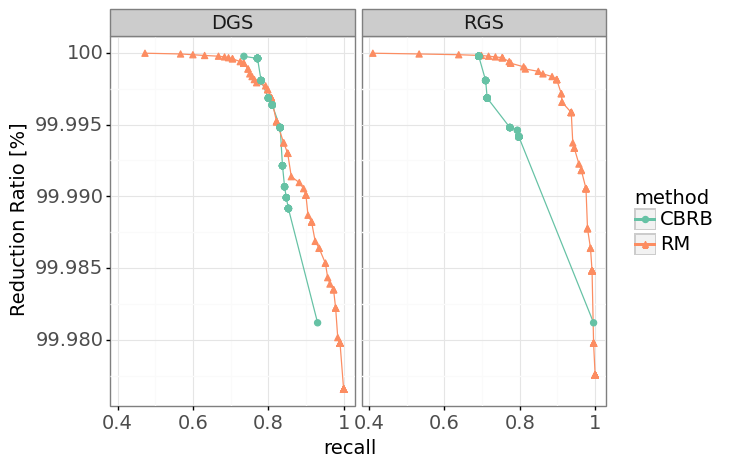

/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/usr/local/lib/python3.8/dist-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: exportedPlots/rrParametrized.png
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/usr/local/lib/python3.8/dist-packages/plotnine/utils.py:371: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [8]:
from plotnine import *

#we can never get worse in terms of reduction ratio if we choose less recall:
def createSmoothedRR(x, finalDF):
    gs = x["GS"]
    method = x["method"]
    dataset = x["dataset"]
    recall = x["recall"]
    sorted = finalDF[(finalDF["dataset"]==dataset) & (finalDF["method"]==method) & (finalDF["GS"]==gs) & (finalDF["recall"]>=recall)].sort_values('rr',ascending=False)
    bestRR = sorted.iloc[0]["rr"]
    return bestRR

reductionRatioSmoothed = finalDF.apply(lambda x: createSmoothedRR(x,finalDF),axis=1)
finalDF["rrSmooth"] = reductionRatioSmoothed
finalDFMAA = finalDF[finalDF['dataset']=="MAA"]
plot = ggplot(finalDFMAA, aes(x ='recall', y='rrSmooth', color="method", shape = "method")) + geom_line() + geom_point(size=2) + theme_bw() + facet_wrap("GS") + theme(text=element_text(size=14)) + ylab("Reduction Ratio [%]") + scale_color_brewer(type="qual",palette="Set2")
print(plot)
plot.save("exportedPlots/rrParametrized.png")

#faceted by dataset:
# finalDFNOMAA = finalDF[finalDF['dataset']!="MAA"]
# finalDFNOMAADGS = finalDFNOMAA[finalDFNOMAA["GS"]=="DGS"]
# finalDFNOMAARGS = finalDFNOMAA[finalDFNOMAA["GS"]=="RGS"]
# plot = ggplot(finalDFNOMAADGS, aes(x ='recall', y='rrSmooth', color="method", shape = "method")) + geom_line() + geom_point(size=2) + theme_bw() + facet_wrap(["dataset"]) +ggtitle("DGS")+ theme(text=element_text(size=14)) + ylab("Reduction Ratio [%]") + theme(axis_text_x = element_text(angle=45)) + scale_color_brewer(type="qual",palette="Set2")
# print(plot)
# plot.save("exportedPlots/rrDGSAll.png")
#
# plot = ggplot(finalDFNOMAARGS, aes(x ='recall', y='rrSmooth', color="method", shape = "method")) + geom_line() + geom_point(size=2) + theme_bw() + facet_wrap(["dataset"]) +ggtitle("RGS")+ theme(text=element_text(size=14)) + ylab("Reduction Ratio [%]") + theme(axis_text_x = element_text(angle=45))
# print(plot)
# plot.save("exportedPlots/rrRGSAll.png")
#
# plot = ggplot(finalDFNOMAA, aes(x ='recall', y='rrSmooth', color="method", shape = "method")) + geom_line() + geom_point(size=2) + theme_bw() + facet_wrap(["dataset","GS"]) +ggtitle(ds)+ theme(text=element_text(size=14)) + ylab("Reduction Ratio [%]") + ylim(99.95,100)
# print(plot)
# for ds in finalDFNOMAA["dataset"].unique():
#     thisDF = finalDFNOMAA[finalDFNOMAA["dataset"]==ds]
#     plot = ggplot(thisDF, aes(x ='recall', y='rrSmooth', color="method", shape = "method")) + geom_line() + geom_point(size=2) + theme_bw() + facet_wrap("GS") +ggtitle(ds)+ theme(text=element_text(size=14)) + ylab("Reduction Ratio [%]")
#     print(plot)

In [9]:
print(finalDFMAA[(finalDFMAA['recall']>=0.95) & (finalDFMAA['GS']=="RGS")])

                 n         rr method  threshold dataset    recall   GS  \
11    1.200396e+07  99.975549     RM       0.00     MAA  1.000000  RGS   
23    1.200396e+07  99.975549     RM       0.01     MAA  1.000000  RGS   
35    1.200396e+07  99.975549     RM       0.02     MAA  1.000000  RGS   
47    1.200396e+07  99.975549     RM       0.03     MAA  1.000000  RGS   
59    1.200396e+07  99.975549     RM       0.04     MAA  1.000000  RGS   
...            ...        ...    ...        ...     ...       ...  ...   
755   4.179464e+06  99.990962     RM       0.62     MAA  0.963506  RGS   
767   3.977826e+06  99.991369     RM       0.63     MAA  0.963506  RGS   
779   3.762006e+06  99.991805     RM       0.64     MAA  0.963506  RGS   
791   3.541777e+06  99.992248     RM       0.65     MAA  0.957060  RGS   
1223  9.127796e+06  99.981199   CBRB       0.00     MAA  0.995920  RGS   

       rrSmooth  
11    99.977562  
23    99.977562  
35    99.977562  
47    99.977562  
59    99.977562  
...